## Проект по модую 3: градиентный бустинг.

Вам предстоит реализовать модель градиентного бустинга, использующий в качестве базового алгортима линейую регрессию. Основная идея такова: Мы хотим заставить модели исправлять ошибки друг друга. Конкретнее, мы обучим модель, которая будет предсказывать результат. Далее вычтим предсказания модели из реальных ответов. Получившаяся разность - допущенная первой моделью ошибка. Далее обучим на этих разностях следующую модель. Она исправит часть ошибок первой модели, но наделает своих. Не беда, снова вычтим ответы второй модели из дынных, на которых она училась, и на получившихся ответах обучим третью модель (третья модель будет учится на оригинальных данных, из которых вычли предсказания первых двух моделей). И так далее. Предсказанием итоговой модели будет сумма предсказаний базовых алгоритмов.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Задача 1 (3 балла).

Вы будете работать с данными о ценах квартир, целевая переменая - median_house_value. Необходимо выполнить предобработку данных. Рекомендация: измеряйте цену не в долларах, а в тысячах долларов.

In [39]:
df_train = pd.read_csv("/content/sample_data/california_housing_train.csv")
df_test = pd.read_csv("/content/sample_data/california_housing_test.csv")
df_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0


In [40]:
X_train = df_train[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']]
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
y_train = df_train['median_house_value'] / 1000

X_test = df_test[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']]
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_test = df_test['median_house_value'] / 1000

Опишите функцию, которая создаёт массив с моделями и обучает их описанным выше способом. Использование классов вместо функций крайне приветствуюется.

In [41]:
def make_and_fit(X_train, y_train, num_of_models):
    models = []
    y_train1 = np.array(y_train.sample(frac=1))
    for i in range(1, num_of_models + 1):
      model = LinearRegression()
      model.fit(X_train, y_train1)
      models.append(model)
      preds = model.predict(X_train)
      y_train1 -= preds
    return models


Опишите функцию (или метод класса) predict.

In [42]:
def predict(X_test, y_test, models):
  preds = np.zeros(len(y_test))
  for i in range((len(models))):
    preds += models[i].predict(X_test)
  return preds

Исследуйте, как зависит MSE от количества моделй. Постройте график MSE(num_of_models).

In [43]:
MSEs = []
numbers = np.arange(1, 21, 1)
for num in numbers:
  models = make_and_fit(X_train, y_train, num)
  preds = predict(X_test, y_test, models)
  MSE = ((y_test - preds) ** 2).mean()
  MSEs.append(MSE)

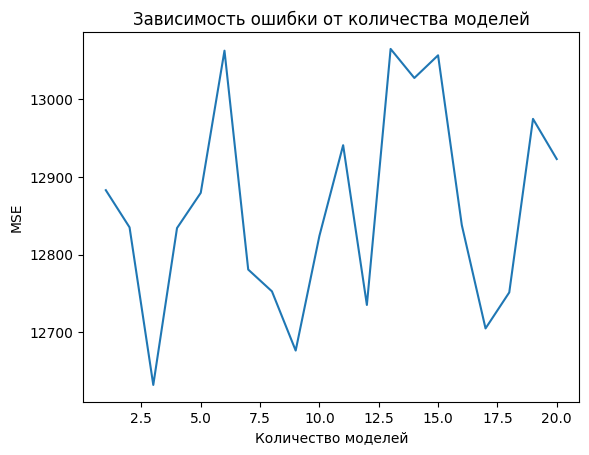

In [44]:
plt.plot(numbers, MSEs)
plt.xlabel("Количество моделей")
plt.ylabel("MSE")
plt.title("Зависимость ошибки от количества моделей")
plt.show()

График получился довольно хаотичным, но при каждой компеляции результат получается разным, так что доверять ему особо сильно не стоит, для анализа лучше будет использовать метод, описанный в задаче 3.

Задача 2 (1 балл). Объясните, почему всё, что было сделано до этого бессмысленно и не может работать лучше обычной линейной регрессии. Ниже вы видете 2 нелинейные функции f и f_1, одна является обратной к другой. Другими солвами f(f_1(x)) = x. Встройте их в код обучения и предсказания модели, чтобы добавить нелинейности. Иными словами, модель номер n должна предсказывать НЕ $$y - \hat{y}_1 - \hat{y}_2 - ... - \hat{y}_{n-1}$$, А
$$f(y - f^{-1}(\hat{y}_1) - f^{-1}(\hat{y}_2) - ... - f^{-1}(\hat{y}_{n-1}))$$

Почему? ...


### Ответ

Градиентный бустинг не особо полезен в данном случае, так как он работает за счет линейной регрессии и не способен "заметить" любую нелинейность (например, квадратичную зависимость).

Предложенный способ действительно поможет добавить немного нелинейности в алгоритм, однако, скорее всего, он же и приведет модель к переобучению.

Проделайте все пункты задачи 1 с улучшенной моделью.

In [45]:
def f(x):
    return np.tan(x)

def f_1(x):
    return np.arctan(x)

def make_and_fit2(X_train, y_train, num_of_models):
    models = []
    y_train1 = np.array(y_train.sample(frac=1))
    for i in range(1, num_of_models + 1):
      model = LinearRegression()
      model.fit(X_train, y_train1)
      models.append(model)
      preds = model.predict(X_train)
      y_train1 = (y_train - f_1(preds)).sample(frac=1)

    return models

def predict(X_test, y_test, models):
  preds = np.zeros(len(y_test))
  for i in range((len(models))):
    preds += models[i].predict(X_test)
  return preds


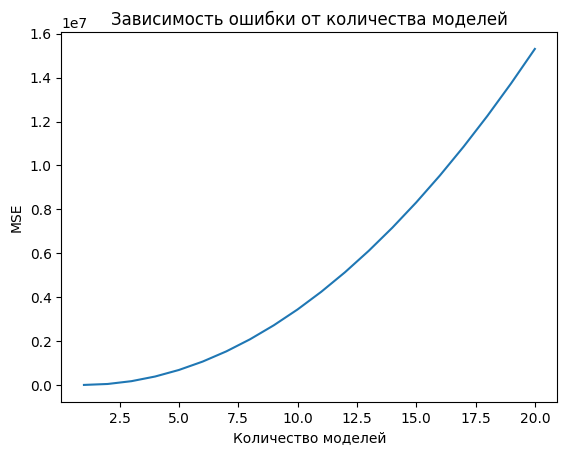

In [46]:
MSEs = []
numbers = np.arange(1, 21, 1)
for num in numbers:
  models = make_and_fit2(X_train, y_train, num)
  preds = predict(X_test, y_test, models)
  MSE = ((y_test - preds) ** 2).mean()
  MSEs.append(MSE)

plt.plot(numbers, MSEs)
plt.xlabel("Количество моделей")
plt.ylabel("MSE")
plt.title("Зависимость ошибки от количества моделей")
plt.show()

Задача 3 (1 балл). Если вы запустите написанный код несколько раз, то заметите, что ломанная получается каждый раз новая. А есть ли какой-то общий тренд? Вам предстоит это изучить. Запустите процесс получения массива с MSE (который вы использовали для построения графиков ранее) 50 раз. Рекомендуется исследовать количество моделей от 1 до 20. После этого возьмите среднее арифметическое от всех 50 MSE для каждого количества моделей. Итого у вас снова получится массив из 20 уже усреднённых MSE. Ваш код будет выполняться в районе 3 минут. Вновь постройте график и сделайте вывод об оптимальном количестве моделей.

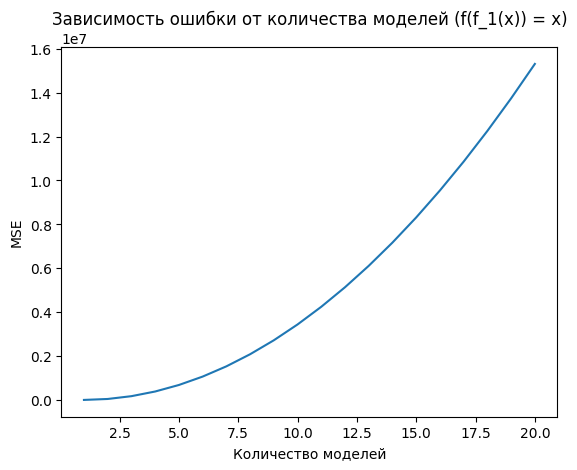

In [47]:
MSEs = []
for num in numbers:
  total = 0
  for _ in range(50):
    new_model = make_and_fit2(X_train, y_train, num)
    preds = predict(X_test, y_test, new_model)
    MSE = ((y_test - preds) ** 2).mean()
    total += MSE
  MSEs.append(total / 50)

plt.plot(numbers, MSEs)
plt.xlabel("Количество моделей")
plt.ylabel("MSE")
plt.title("Зависимость ошибки от количества моделей (f(f_1(x)) = x)")
plt.show()


Как и было сказано ранее, данный подход привел к переобучению, число увеличение числа моделей лишь ухудшает результат.

Давайте попробуем провести подобный анализ для градиентного бустинга:


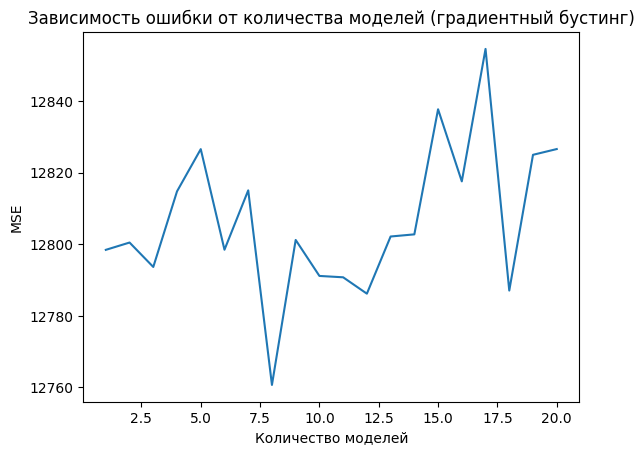

In [48]:
MSEs = []
for num in numbers:
  total = 0
  for _ in range(50):
    new_model = make_and_fit(X_train, y_train, num) #используем 1-й вариант make_and_fit
    preds = predict(X_test, y_test, new_model)
    MSE = ((y_test - preds) ** 2).mean()
    total += MSE
  MSEs.append(total / 50)

plt.plot(numbers, MSEs)
plt.xlabel("Количество моделей")
plt.ylabel("MSE")
plt.title("Зависимость ошибки от количества моделей (градиентный бустинг)")
plt.show()

При использовании градиентного бустинга переобучение также происходит, но не сразу. В среднем лучшим количеством моделей является 8.